In [1]:
%matplotlib inline
import sys
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy as sp
import IPython
import sklearn
from IPython.display import display
import mglearn

print(f'Python version: {sys.version}')
print(f'pandas version: {pd.__version__}')
print(f'matplotlib version: {matplotlib.__version__}')
print(f'NumPy version: {np.__version__}')
print(f'SciPy version: {sp.__version__}')
print(f'IPython version: {IPython.__version__}')
print(f'scikit-learn version: {sklearn.__version__}')

/Users/matthewmckenna/miniconda3/envs/intro-to-ml/lib/python3.7/site-packages/sklearn/utils/__init__.py:4: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated, and in 3.8 it will stop working
  from collections import Sequence


Python version: 3.7.0 (default, Jun 28 2018, 07:39:16) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
pandas version: 0.23.4
matplotlib version: 2.2.3
NumPy version: 1.15.1
SciPy version: 1.1.0
IPython version: 6.4.0
scikit-learn version: 0.19.1


# Decision Trees

Decision trees are widely used models for classification and regression.

As an example, imagine you want to distinguish between the following four animals: bears, hawks, penguins, and dolphins.
The goal is to get the answer right by asking as few if/else questions as possible.
This series of questions can be expressed as a decision tree, as shown below:

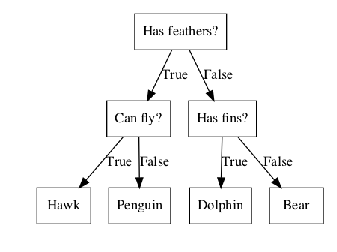

In [2]:
mglearn.plots.plot_animal_tree()

Each node in the tree represents a question, or a terminal node (or leaf) that contains the answer.
The edges connect the answers to a question with the next question you would ask.

There are three features: "has feathers", "can fly", "has fins".

## Building decision trees

We'll build a decision tree for a 2D classification dataset.
The dataset consits of two half-moonshapes, with each class having 75 data points.
This is the `two_moons` dataset.

The questions asked by the model are known as *tests*.
Usually data does not come in the form of binary yes/no features, but instead represented as continuous features.
The tests used on continuous data are of the form "Is feature *i* larger than value *a*?"

To build a tree, the algorithm searches over all possible tests and finds the one that is most informative about the target variable.
Splitting the dataset vertically at `x[1]=0.0596` yields the most information; it best separates the points in class 0 from the points in class 1.

The top node, also known as the *root*, represents the whole dataset, consiting of 75 points belonging to class 0 and 75 points belonging to class 1.
The split is done by testing whether `x1 <= 0.596` indicated by the line.
If the test is true, a point is assigned to the left node, which contains 2 points belonging to class 0, and 32 points belonging to class 1.
Otherwise the point is assigned to the right node, which contains 48 points belonging to class 0, and 18 points belonging to class 1.

We can bulid more accurate models by repeating the process of looking for the best test in both regions.
This process yields a binary tree of decisions, with each node containing a test.
Each test can be thought of as splitting the data currently being considered along one axis.

The recursive partitioning of the data is repeated until each region in the partition (each leaf in the tree) only contains a single target value.
A leaf of the tree that contains data points that all share the same target value is called *pure*.

A predicition on a new data point is made by checking which region of the partition of the feature space that point lies in, and then predicting the majority target.

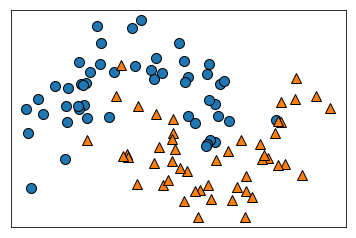

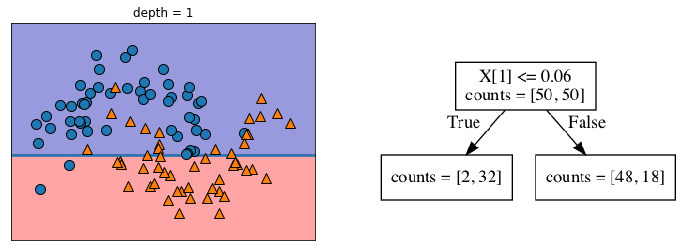

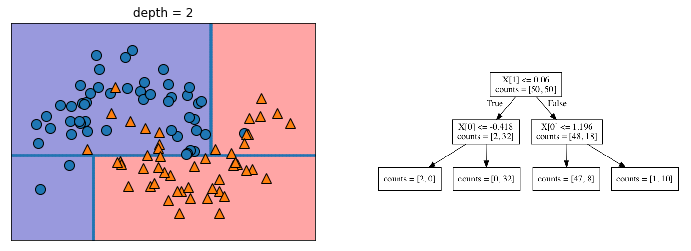

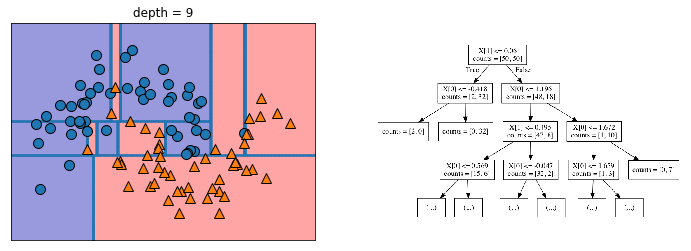

In [3]:
mglearn.plots.plot_tree_progressive()

## Controlling complexity

Building trees and continuing until all leaves are pure leads to models that are very complex, and highly overfit.
Pure leaves mean that a tree is 100% accurate on the training data.

There are two common strategies to prevent overfitting: stopping the creating of the tree early (*pre-pruning*), or buliding the tree but then removing or collapsing nodes that contain little information (*post-pruning* or just *pruning*).

Pre-pruning criteria include limiting the maximum depth of the tree, limiting the maximum number of leaves, or requiring a minimum number of points in a node to keep splitting.

Decision rrees are implemented using the `DecisionTreeRegressor` and `DecisionTreeClassifier` classes.
`scikit-learn` only implements pre-pruning.

We'll look at the effect of pre-pruning on the Breast Cancer dataset.

In [4]:
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

cancer = load_breast_cancer()
X_train, X_test, y_train, y_test = train_test_split(
    cancer.data,
    cancer.target,
    stratify=cancer.target,
    random_state=42,
)
tree = DecisionTreeClassifier(random_state=0)
tree.fit(X_train, y_train)
print(f'Accuracy on training set: {tree.score(X_train, y_train):.3f}')
print(f'Accuracy on test set: {tree.score(X_test, y_test):.3f}')

Accuracy on training set: 1.000
Accuracy on test set: 0.937


The accuracy on the training set is 100% as expected.
The tree was grown deep enough that it could perfectly memorise all the labels on the training data.
The test accuracy is slightly worse than for the linear models, which had around 95% accuracy.

If we don't restrict the depth of a decision tree, the tree can become arbitrarily deep and complex.
Let's now apply pre-pruning to the tree.

In [5]:
tree = DecisionTreeClassifier(max_depth=4, random_state=0)
tree.fit(X_train, y_train)

print(f'Accuracy on training set: {tree.score(X_train, y_train):.3f}')
print(f'Accuracy on test set: {tree.score(X_test, y_test):.3f}')

Accuracy on training set: 0.988
Accuracy on test set: 0.951


## Analysing decision trees

We can visualise the tree using the `export_graphviz` function of the `tree` module.
This writes a file in the *.dot* file format, which is a text file for storing graphs.

In [6]:
from sklearn.tree import export_graphviz

export_graphviz(
    tree,
    out_file='tree.dot',
    class_names=['malignant', 'benign'],
    feature_names=cancer.feature_names,
    impurity=False,
    filled=True,
)

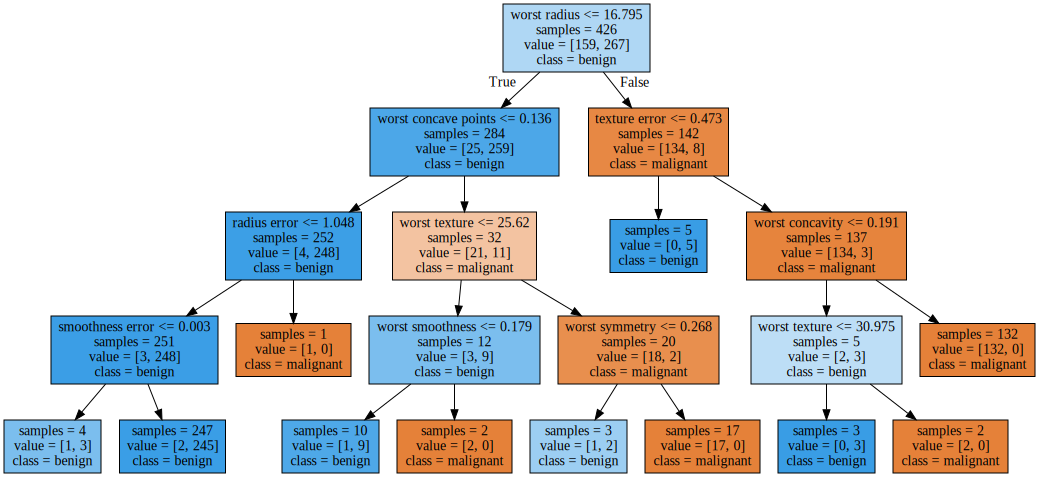

In [7]:
import graphviz

with open('tree.dot') as f:
    dot_graph = f.read()

graphviz.Source(dot_graph)

This visualisation provides an in-depth view of how the algorithm makes predictions, and can easily be explained to non-experts.

However, even with a depth of four (as above) the tree can be overwhelming.
Deeper trees (depths of 10 are not uncommon) are even harder to understand.

One method of inspecting the tree is to find out which path most of the data actually takes.
The `n_samples` shown in each node gives the number of samples in the node, while the `value` provides the number of samples per class.

## Feature importance in trees

Instead of looking at the entire tree, there are some useful properties that we can derive to summarise the workings of the tree.

The most commonly used summary is *feature importance*, which rates how important each feature is for the decision a tree makes.
This is a number between 0 and 1, where 0 means "not used at all" and 1 means "perfectly predicts the target".
The feature importances always sum to 1.

In [8]:
print(f'Feature importances:\n{tree.feature_importances_}')

Feature importances:
[0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.01019737 0.04839825
 0.         0.         0.0024156  0.         0.         0.
 0.         0.         0.72682851 0.0458159  0.         0.
 0.0141577  0.         0.018188   0.1221132  0.01188548 0.        ]


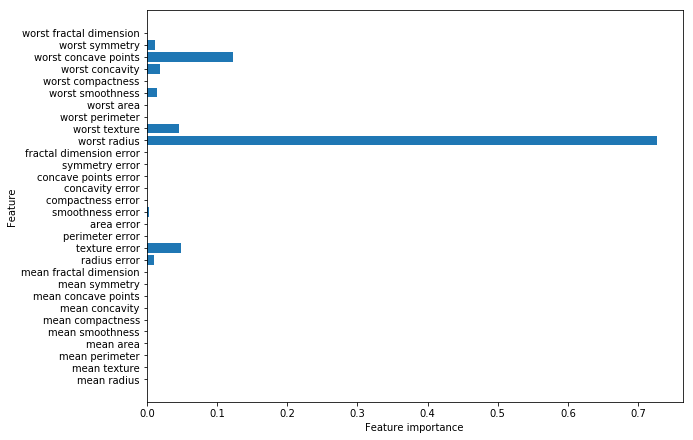

In [9]:
def plot_feature_importances_cancer(model):
    plt.figure(figsize=(9.6, 7.2))
    n_features = cancer.data.shape[1]
    plt.barh(range(n_features), model.feature_importances_, align='center')
    plt.yticks(np.arange(n_features), cancer.feature_names)
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances_cancer(tree)

We see that the feature used in the top split `worst radius` is by far the most important feature.

A feature with a low `feature_importance` does not mean that the feature is uninformative.
It only means that the feature was not picked by the tree, likely because another feature encodes the same information.

Feature importances are always positive, and don't encode which class a feature is indicative of.

Feature importances: [0. 1.]


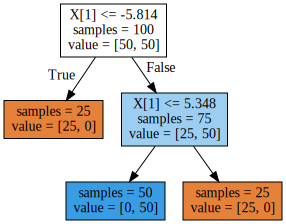

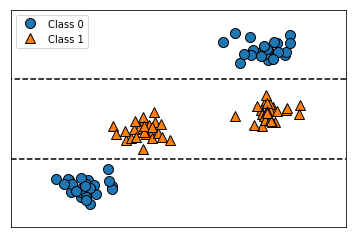

In [10]:
tree = mglearn.plots.plot_tree_not_monotone()
display(tree)

The dataset above contains two features and two classes.
All the information is contained in `X[1]`, and `X[0]` is not used at all.

The relation between `X[1]` and the output class is not monotonous, meaning we cannot say "a high value of `X[1]` means class 0, and a low value means class 1".

The usage and analysis of regression trees is very similar to that of classification trees.
However, there's an important property of tree-based regression models.
The `DecisionTreeRegressor` is not able to *extrapolate* or make predictions outside of the range of the training data.

Let's look at a dataset of historical computer memory (RAM) prices.
The figure below shows the date on the x-axis and the price of one megabyte of RAM in that year on the y-axis.

Text(0,0.5,'Price in $/Megabyte')

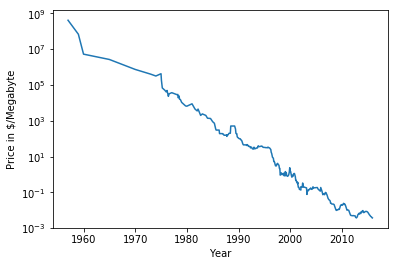

In [11]:
ram_prices = pd.read_csv('data/ram_price.csv')

plt.semilogy(ram_prices.date, ram_prices.price)
plt.xlabel('Year')
plt.ylabel('Price in $/Megabyte')

We use a logarithmic scale on the y-axis.
When plotting logarithmically, the relationship seems to be quite linear, and so should be relatively easy to predict, apart from some bumps.

We will make a forecast for the years after 2000 using the historical data up to that point, with the date as our only feature.
We'll compare two simple models: `DecisionTreeRegressor` and `LinearRegression`.
We'll rescale the prices using a logarithm, so that the relationship is relatively linear.
This doesn't make a difference for `DecisionTreeRegressor`, but makes a big difference for `LinearRegression`.

After training the models and making predictions, we'll apply the exponential map to undo the log transform.

In [12]:
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# use historical data to forecast prices after the year 2000
data_train = ram_prices[ram_prices.date < 2000]
data_test = ram_prices[ram_prices.date >= 2000]

# predict prices based on date
# [:, np.newaxis] converts from shape (202, ) -> (202, 1)
# data_train.date[0] goes from
# 1957.0 -> array([1957.])
X_train = data_train.date[:, np.newaxis]
# use a log-transform to get a simpler relationship of data to target
y_train = np.log(data_train.price)

tree = DecisionTreeRegressor().fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)

# predict on all data
X_all = ram_prices.date[:, np.newaxis]

pred_tree = tree.predict(X_all)
pred_lr = linear_reg.predict(X_all)

# undo log-transform
price_tree = np.exp(pred_tree)
price_lr = np.exp(pred_lr)

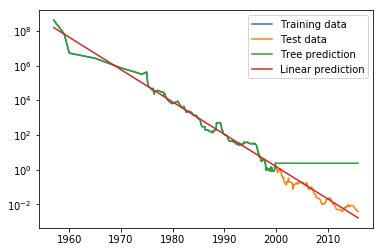

In [13]:
# plt.figure(figsize=(9.6, 7.2))
plt.semilogy(data_train.date, data_train.price, label='Training data')
plt.semilogy(data_test.date, data_test.price, label='Test data')
plt.semilogy(ram_prices.date, price_tree, label='Tree prediction')
plt.semilogy(ram_prices.date, price_lr, label='Linear prediction')
plt.legend()

The difference between the models is quite striking.
The linear model provides quite a good forecast for the test data (after 2000) while glossing over some of the finer variations in both the training and test data.

The tree model, on the other hand, makes perfect predictions on the training data, however, once we leave the data range for which the model has data, the model simply keeps predicting the last known point.

## Strengths, weaknesses, and parameters

Parameters:

* pre-pruning
  * `max_depth`
  * `max_leaf_nodes`
  * `min_leaf_samples`
  * one of the above is usually enough

Strengths:

* resulting model can be easily visualised and understood by non-experts
* algorithms are completely invariant to scaling of the data
  * each feature is processed separately, and splits of data don't depend on scaling.
  * no preprocessing like normalisation or standardisation are needed.
* work well when you have features on completely different scales, or mix of binary and continuous features

Weaknesses:

* tend to overfit and provide poor generalisation performance

Ensemble methods usually used in place of a single decision tree.